# 0.0 Understanding the Situation

- objective of the proposed situation
1. Prediction of the first destination a new user will choose
- Why?
 - What kind of business model does Airbnb have?
 - Market Place (connecting people who offer accommodation with people who are looking for accommodation)
 - Offer (people offer accommodation)
   - Portifolio size
   - Portfolio diversity/density
   - Average price
 - Demand (people looking for accommodation)
   - Number of Users
   - LTV (Lifetime Value)
   - CAC (Client Acquisition Cost)
 - Gross Revenue  = fee * number of users - CAC (contribution margins)
 
 
- **Solution**
 - Prediction model of the first destination of a new user
 - API
   - **Input**: user and its characteristics
   - **Output**: user and its characteristics **with the prediction of destination**

# 1.0 IMPORTS

## 1.1 Libraries

In [33]:
#!pip install scikit-plot

In [34]:
import random
import pandas as pd  # pip install pandas
import numpy as np # pip install numpy
import seaborn as sns # pip install seaborn
from sklearn.model_selection import train_test_split, StratifiedKFold  # pip install sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, balanced_accuracy_score, cohen_kappa_score, classification_report
from scikitplot.metrics import plot_confusion_matrix  # pip install scikit-plot
from keras.models import Sequential  # pip install keras; pip install tensorflow
from keras.layers import Dense

## 1.2 Helper Functions

## 1.3 Loading data

In [35]:
!ls -l ../01-Data/csv_data

total 648652
-rw-r--r-- 1 fabio 197609     11905 Oct 16  2015 age_gender_bkts.csv
-rw-r--r-- 1 fabio 197609       632 Oct 16  2015 countries.csv
-rw-r--r-- 1 fabio 197609    931451 Dec  6  2015 sample_submission_NDF.csv
-rw-r--r-- 1 fabio 197609 631646292 Dec  6  2015 sessions.csv
-rw-r--r-- 1 fabio 197609   6763170 May 16  2018 test_users.csv
-rw-r--r-- 1 fabio 197609  24853881 Dec 10  2015 train_users_2.csv


### 1.3.1 Training

In [36]:
df_train_raw = pd.read_csv(
    "../01-Data/csv_data/train_users_2.csv", low_memory=True)
df_train_raw.shape

(213451, 16)

### 1.3.2 Sessions

In [37]:
df_sessions_raw = pd.read_csv(
    "../01-Data/csv_data/sessions.csv", low_memory=True)
df_sessions_raw.shape

(10567737, 6)

# 2.0 DATA DESCRIPTION

In [104]:
df_train_01 = df_train_raw.copy()
df_sessions_01 = df_sessions_raw.copy()

## 2.1 Training

### 2.1.1 Data Dimensions

In [105]:
print(f'Number of Rows: {df_train_01.shape[0]}')
print(f'Number of Columns: {df_train_01.shape[1]}')

Number of Rows: 213451
Number of Columns: 16


### 2.1.2 Data Type

In [106]:
df_train_01.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

### 2.1.3 NA Check

In [107]:
df_train_01.isnull().sum() / len(df_train_01)

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [108]:
aux = df_train_01[df_train_01['date_first_booking'].isnull()]
aux['country_destination'].value_counts(normalize=True)

NDF    1.0
Name: country_destination, dtype: float64

In [109]:
aux = df_train_01[df_train_01['age'].isnull()]
aux['country_destination'].value_counts(normalize=True)

NDF      0.768428
US       0.156529
other    0.028617
FR       0.014888
IT       0.009081
GB       0.006251
ES       0.006171
CA       0.003989
DE       0.002387
NL       0.001818
AU       0.001171
PT       0.000671
Name: country_destination, dtype: float64

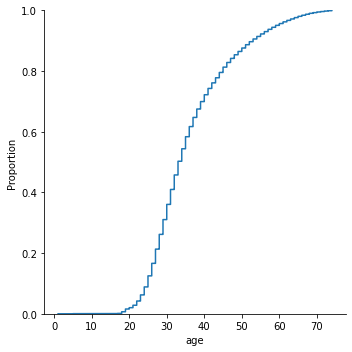

In [110]:
sns.displot(df_train_01[df_train_01['age']<75]['age'], kind='ecdf');

In [111]:
df_train_01['first_affiliate_tracked'].drop_duplicates()

0            untracked
5                  omg
12                 NaN
13              linked
79       tracked-other
257            product
6270         marketing
11184        local ops
Name: first_affiliate_tracked, dtype: object

In [112]:
# remove missing values completely
#df_train_01 = df_train_01.dropna()

# date_first_booking
date_first_booking_max = pd.to_datetime(df_train_01['date_first_booking']).max().strftime('%Y-%m-%d')
df_train_01['date_first_booking'] = df_train_01['date_first_booking'].fillna(date_first_booking_max)

# age
avg_age = int(df_train_01['age'].mean())
df_train_01['age'] = df_train_01['age'].fillna(avg_age)

# first_affiliate_tracked
# remove missing values completely
df_train_01 = df_train_01[~df_train_01['first_affiliate_tracked'].isnull()]

df_train_01.shape

(207386, 16)

### 2.1.4 Change Data type 

In [43]:
# date_account_created
df_train_01['date_account_created'] = pd.to_datetime(
    df_train_01['date_account_created'])
# timestamp_first_active
df_train_01['timestamp_first_active'] = pd.to_datetime(
    df_train_01['timestamp_first_active'], format='%Y%m%d%H%M%S')
# date_first_booking
df_train_01['date_first_booking'] = pd.to_datetime(
    df_train_01['date_first_booking'])

# age
df_train_01['age'] = df_train_01['age'].astype(int)

In [44]:
df_train_01.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int32
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

### 2.1.5 Check Balanced Data

In [45]:
df_train_01['country_destination'].value_counts(normalize=True)

US       0.708864
other    0.110854
FR       0.054085
IT       0.029763
GB       0.025935
ES       0.024864
CA       0.015696
DE       0.012454
NL       0.008801
AU       0.006366
PT       0.002318
Name: country_destination, dtype: float64

## 2.2 Sessions

### 2.2.1 Data Dimensions

In [62]:
print(f'Number of Rows: {df_sessions_01.shape[0]}')
print(f'Number of Columns: {df_sessions_01.shape[1]}')

Number of Rows: 10567737
Number of Columns: 6


### 2.2.2 Data Type

In [63]:
df_sessions_01.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

### 2.2.3 NA Check

In [65]:
df_sessions_01.isnull().sum() / len(df_sessions_01)

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

In [113]:
# remove missing values completely
## user_id - 0.3%
df_sessions_01 = df_sessions_01[~df_sessions_01['user_id'].isnull()]

## action - 0.75%
df_sessions_01 = df_sessions_01[~df_sessions_01['action'].isnull()]

## action_type - 10.65%
df_sessions_01 = df_sessions_01[~df_sessions_01['action_type'].isnull()]

## action_detail - 10.65%
df_sessions_01 = df_sessions_01[~df_sessions_01['action_detail'].isnull()]

## secs_elapsed - 1.3%
df_sessions_01 = df_sessions_01[~df_sessions_01['secs_elapsed'].isnull()]

df_sessions_01.shape

(9213930, 6)

# 3.0 Data Filtering

In [46]:
df_train_02 = df_train_01.copy()

# 4.0 Data Preparation

In [47]:
df_train_03 = df_train_02.copy()

In [48]:
# Dummy variable
df_train_03_dummy = pd.get_dummies(
    df_train_03.drop(['id', 'country_destination'], axis=1))

# Join id and country_destination
df_train_03 = pd.concat(
    [df_train_03[['id', 'country_destination']], df_train_03_dummy], axis=1)

# 5.0 Feature Selection

## 5.1 Drop Columns

In [49]:
cols_drop = [
    'date_account_created', 'timestamp_first_active', 'date_first_booking',
    'id'
]  # orginal dates
df_train_04 = df_train_03.drop(cols_drop, axis=1)

## 5.2 Split into Train and Validation 

In [50]:
X = df_train_04.drop('country_destination', axis=1)
y = df_train_04['country_destination'].copy()

# Split dataset into train and validation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=32)

# 6.0 Machine Learning Model

## 6.1 Baseline model

### 6.1.1 Random Choices

In [51]:
country_destination_list = y_train.drop_duplicates().sort_values().tolist()
country_destination_weights = y_train.value_counts(
    normalize=True).sort_index().tolist()
k_num = y_test.shape[0]

# Random Model

yhat_random = random.choices(population=country_destination_list,
                             weights=country_destination_weights,
                             k=k_num)

### 6.1.2 Random Choices Performance

Accuracy: 0.5203520352035204
Balanced Accuracy: 0.09398885255776462
Kappa Score: 0.003974122353482601
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       101
          CA       0.03      0.02      0.02       214
          DE       0.01      0.01      0.01       170
          ES       0.03      0.03      0.03       345
          FR       0.06      0.06      0.06       710
          GB       0.02      0.02      0.02       344
          IT       0.05      0.04      0.04       423
          NL       0.02      0.02      0.02       128
          PT       0.00      0.00      0.00        36
          US       0.71      0.71      0.71      9624
       other       0.12      0.12      0.12      1540

    accuracy                           0.52     13635
   macro avg       0.09      0.09      0.09     13635
weighted avg       0.52      0.52      0.52     13635



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

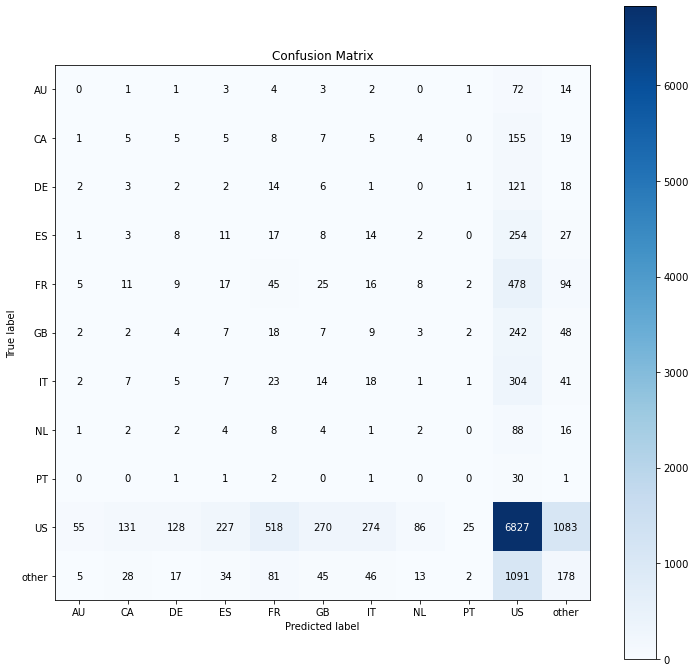

In [52]:
# Accuracy
acc_random = accuracy_score(y_test, yhat_random)
print('Accuracy: {}'.format(acc_random))

# Balanced Accuracy
balanced_acc_random = balanced_accuracy_score(y_test, yhat_random)
print('Balanced Accuracy: {}'.format(balanced_acc_random))

# Kappa Score
kappa_random = cohen_kappa_score(y_test, yhat_random)
print('Kappa Score: {}'.format(kappa_random))

# Classification Report
print(classification_report(y_test, yhat_random))

# Confusion matrix
plot_confusion_matrix(y_test, yhat_random, normalize=False, figsize=(12, 12))

## 6.2 Machine Learning Model - Neural Network MLP

### 6.2.1 Target Encoding

In [53]:
ohe = OneHotEncoder()
y_train_nn = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()

### 6.2.2 NN Model

In [54]:
# Model Definition
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(11, activation='softmax'))

# Model compile
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

# Train Model
model.fit(X_train, y_train_nn, epochs=100)

Epoch 1/100
1705/1705 [==============================] - 1s 629us/step - loss: 1.4320 - accuracy: 0.6858
Epoch 2/100
1705/1705 [==============================] - 1s 651us/step - loss: 1.3248 - accuracy: 0.7055
Epoch 3/100
1705/1705 [==============================] - 1s 657us/step - loss: 1.2272 - accuracy: 0.70870s - loss: 1.2262 - accuracy
Epoch 4/100
1705/1705 [==============================] - 1s 643us/step - loss: 1.2199 - accuracy: 0.7075
Epoch 5/100
1705/1705 [==============================] - 1s 641us/step - loss: 1.1905 - accuracy: 0.7078
Epoch 6/100
1705/1705 [==============================] - 1s 633us/step - loss: 1.1884 - accuracy: 0.7052
Epoch 7/100
1705/1705 [==============================] - 1s 623us/step - loss: 1.1592 - accuracy: 0.7102
Epoch 8/100
1705/1705 [==============================] - 1s 653us/step - loss: 1.1594 - accuracy: 0.7083
Epoch 9/100
1705/1705 [==============================] - 1s 646us/step - loss: 1.1428 - accuracy: 0.7106
Epoch 10/100
1705/1705 [===

1705/1705 [==============================] - 1s 620us/step - loss: 1.0969 - accuracy: 0.7130
Epoch 79/100
1705/1705 [==============================] - 1s 614us/step - loss: 1.1072 - accuracy: 0.7091
Epoch 80/100
1705/1705 [==============================] - 1s 620us/step - loss: 1.0982 - accuracy: 0.7132
Epoch 81/100
1705/1705 [==============================] - 1s 639us/step - loss: 1.0936 - accuracy: 0.7137
Epoch 82/100
1705/1705 [==============================] - 1s 615us/step - loss: 1.1040 - accuracy: 0.7109
Epoch 83/100
1705/1705 [==============================] - 1s 614us/step - loss: 1.0941 - accuracy: 0.7140
Epoch 84/100
1705/1705 [==============================] - 1s 613us/step - loss: 1.0975 - accuracy: 0.7117
Epoch 85/100
1705/1705 [==============================] - 1s 616us/step - loss: 1.1069 - accuracy: 0.7092
Epoch 86/100
1705/1705 [==============================] - 1s 618us/step - loss: 1.0991 - accuracy: 0.71150s - loss: 1.0978 
Epoch 87/100
1705/1705 [=================

### 6.2.3 NN Performance

In [55]:
# Prediction
pred_nn = model.predict(X_valid)

# Inver Prediction
yhat_nn = ohe.inverse_transform(pred_nn)

# Prediction Prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape(1, -1)[0]

Accuracy: 0.7047304730473047
Balanced Accuracy: 0.0926821320023285
Kappa Score: 0.0027452318960946576


C:\Users\fabio\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       101
          CA       0.00      0.00      0.00       214
          DE       0.50      0.01      0.02       170
          ES       0.00      0.00      0.00       345
          FR       0.00      0.00      0.00       710
          GB       0.33      0.00      0.01       344
          IT       0.29      0.00      0.01       423
          NL       0.00      0.00      0.00       128
          PT       0.00      0.00      0.00        36
          US       0.71      1.00      0.83      9624
       other       0.33      0.00      0.01      1540

    accuracy                           0.70     13635
   macro avg       0.20      0.09      0.08     13635
weighted avg       0.56      0.70      0.58     13635



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

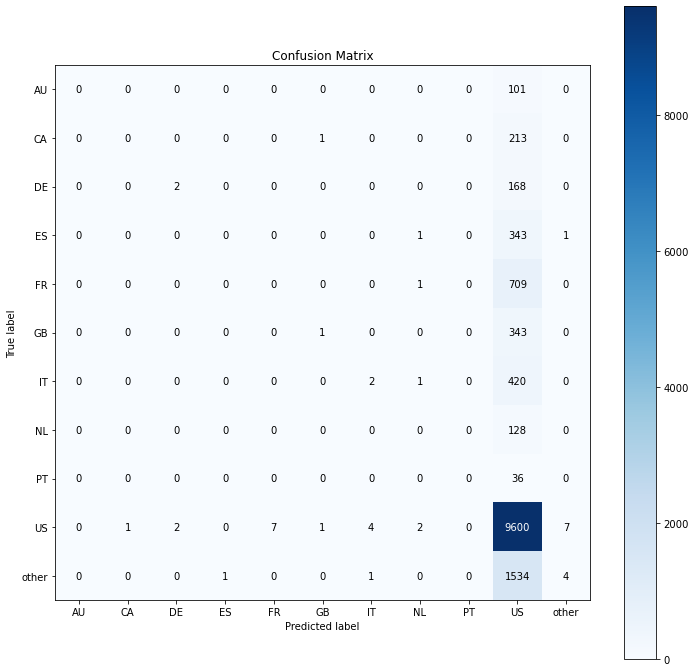

In [56]:
# Accuracy
acc_nn = accuracy_score(y_test_nn, yhat_nn)
print('Accuracy: {}'.format(acc_nn))

# Balanced Accuracy
balanced_acc_nn = balanced_accuracy_score(y_test_nn, yhat_nn)
print('Balanced Accuracy: {}'.format(balanced_acc_nn))

# Kappa Score
kappa_nn = cohen_kappa_score(y_test_nn, yhat_nn)
print('Kappa Score: {}'.format(kappa_nn))

# Classification Report
print(classification_report(y_test_nn, yhat_nn))

# Confusion matrix
plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False, figsize=(12, 12))

### 6.2.4 NN Performance - Cross Validation

In [58]:
# k-fold generate
num_folds = 5
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=32)

balanced_acc_list = []
kappa_acc_list = []

i = 1
for train_ix, val_ix in kfold.split(X_train, y_train):
    print('Fold Number: {}/{}'.format(i, num_folds))
    # get fold
    X_train_fold = X_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    X_val_fold = X_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    
    # target encoding
    ohe = OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform(y_train_fold.values.reshape(-1, 1)).toarray()
    
    # model definition
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_fold.shape[1], activation='relu'))
    model.add(Dense(11, activation='softmax'))

    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # training model
    model.fit(X_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=0)

    # prediction
    pred_nn = model.predict(X_val_fold)
    yhat_nn = ohe.inverse_transform(pred_nn)
    
    # prepare data
    y_test_nn = y_val_fold.to_numpy()
    yhat_nn = yhat_nn.reshape(1, -1)[0]

    # metrics
    ## Balanced Accuracy
    balanced_acc_nn = balanced_accuracy_score(y_test_nn, yhat_nn)
    balanced_acc_list.append(balanced_acc_nn)
    
    ## Kappa Metrics
    kappa_acc_nn = cohen_kappa_score(y_test_nn, yhat_nn)
    kappa_acc_list.append(kappa_acc_nn)
    
    i+=1

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


In [114]:
print('Avg Balanced Accuracy: {} +/- {}'.format(np.round(np.mean(balanced_acc_list),4), np.round(np.std(balanced_acc_list),4)))
print('Avg Kappa: {} +/- {}'.format(np.round(np.mean(kappa_acc_list),4), np.round(np.std(kappa_acc_list),4)))

Avg Balanced Accuracy: 0.0913 +/- 0.0003
Avg Kappa: 0.0021 +/- 0.0012
